In [1]:
# 1. Scarica il dataset da Google Drive
#import gdown

#url = "https://drive.google.com/drive/folders/10QLYLC6jmjRiKngnwg9J2bgs4E4AjVmC?usp=drive_link"
#output_dir = "./content/UWF-ZeekDataFall22"

#gdown.download_folder(url, output=output_dir, quiet=False)


In [2]:
# 2. Installa librerie necessarie
!pip install pyspark pyarrow scikit-learn shap lime matplotlib seaborn pandas numpy imbalanced-learn

  Using cached pyspark-4.0.0-py2.py3-none-any.whl
  Using cached pyarrow-20.0.0-cp310-cp310-win_amd64.whl.metadata (3.4 kB)
  Using cached scikit_learn-1.7.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached shap-0.48.0-cp310-cp310-win_amd64.whl.metadata (25 kB)
  Using cached lime-0.2.0.1-py3-none-any.whl
  Using cached matplotlib-3.10.3-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.61.2-cp310-cp310-win_amd64.whl.metadata (2.9 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached scikit_image-0.25.2-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl

In [3]:
# 3. Configura Spark per leggere Parquet
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("UWFZeekXAI") \
    .config("spark.sql.parquet.enableVectorizedReader", "false") \
    .getOrCreate()

In [4]:
# 📁 4. Carica i file Parquet tranne quelli delle metriche
import glob

parquet_files = glob.glob("./UWF-ZeekDataFall22/parquet/2021*/*.snappy.parquet")
parquet_files += glob.glob("./UWF-ZeekDataFall22/parquet/2022*/*.snappy.parquet")
parquet_files = [f for f in parquet_files if "_parquet_" not in f]

# 📊 Carica il dataset in un DataFrame Spark
df_spark = spark.read.parquet(*parquet_files)
df_spark.createOrReplaceTempView("zeek_data")

print(df_spark.groupBy("label_binary").count().toPandas())

# 🚨 Filtra solo le tattiche MITRE ATT&CK di interesse
filtered_df = spark.sql("""
SELECT
  orig_pkts, resp_pkts, orig_bytes, resp_bytes, duration,
  proto, service, conn_state, history,
  label_binary, label_tactic, label_technique
FROM zeek_data
""")
# 📥 Scarica in Pandas per analisi locale
df_pandas = filtered_df.toPandas()
print("Shape:", df_pandas.shape)
df_pandas.head()

print(df_pandas['label_binary'].value_counts())

  label_binary   count
0        False  350339
1         True  346933
2    Duplicate    3068
Shape: (700340, 12)
label_binary
False        350339
True         346933
Duplicate      3068
Name: count, dtype: int64


In [5]:
# 🧮 5. Calcolo feature derivate utili
def safe_div(x, y):
    return x / y.replace(0, 1).astype(float)

df_pandas['pktAtsec'] = safe_div(df_pandas['orig_pkts'], df_pandas['duration'])
df_pandas['BitRate'] = safe_div((df_pandas['orig_bytes'] + df_pandas['resp_bytes']) * 8, df_pandas['duration'])
df_pandas['interTime'] = safe_div(df_pandas['duration'], df_pandas['orig_pkts'])
df_pandas['avgLenPkt'] = safe_div(df_pandas['orig_bytes'], df_pandas['orig_pkts'])

# 📈 Aggiungi feature aggregate
df_pandas['numPKT'] = df_pandas['orig_pkts'] + df_pandas['resp_pkts']
df_pandas['numBytes'] = df_pandas['orig_bytes'] + df_pandas['resp_bytes']

In [6]:
# 🧹 6. Preprocessing avanzato con One-Hot Encoding e Standardizzazione
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

continuous_features = ['orig_pkts', 'resp_pkts', 'orig_bytes', 'resp_bytes', 'duration', 'pktAtsec', 'BitRate', 'interTime', 'avgLenPkt']
categorical_features = ['proto', 'service', 'conn_state']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),          # Imputation per numeriche
        ('scaler', StandardScaler())
    ]), continuous_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), # Imputation per categoriche
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

In [7]:
# 🎯 7. Encoding etichette
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Y binario (gestione stringhe e numeri)
y_binary = df_pandas['label_binary'].replace({"True": 1, "False": 0, "Duplicate": 1}).astype(int)
# Y multiclasse
tactic_encoder = LabelEncoder()
y_tactic = tactic_encoder.fit_transform(df_pandas['label_tactic'].astype(str))

# 📊 8. Suddivisione train/test UNA SOLA VOLTA per tutto!
X_train, X_test, y_binary_train, y_binary_test, y_tactic_train, y_tactic_test = train_test_split(
    df_pandas[continuous_features + categorical_features], y_binary, y_tactic, test_size=0.2, stratify=y_binary, random_state=42
)

print("Train set:", np.bincount(y_binary_train))
print("Test set:", np.bincount(y_binary_test))
print(np.unique(y_binary_train))

# 🧠 9. Applica il preprocessor ai dati train/test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 🏷️ 10. Ricava i nomi delle feature dopo OHE (usato in XAI)
processed_cat_features = preprocessor.named_transformers_['cat']['ohe'].get_feature_names_out(categorical_features)
all_feature_names = continuous_features + list(processed_cat_features)


C:\Users\CAIS LAB\AppData\Local\Temp\ipykernel_69192\4024819625.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_binary = df_pandas['label_binary'].replace({"True": 1, "False": 0, "Duplicate": 1}).astype(int)


Train set: [280271 280001]
Test set: [70068 70000]
[0 1]


In [8]:
# 🌲 11. Addestramento modelli interpretabili
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Naive Bayes": GaussianNB()
}

# 🧪 12. Addestra e stampa stato
for name, model in models.items():
    try:
        model.fit(X_train_processed, y_binary_train)
        print(f"[✅] {name} addestrato per classificazione binaria")
    except Exception as e:
        print(f"[❌] Errore nel training {name}: {e}")

[✅] Random Forest addestrato per classificazione binaria
[✅] Decision Tree addestrato per classificazione binaria
[✅] Logistic Regression addestrato per classificazione binaria
[✅] Naive Bayes addestrato per classificazione binaria


In [9]:
# 📊 13. Valutazione dei modelli binari
from sklearn.metrics import classification_report

results_binary = {}
for name, model in models.items():
    try:
        y_pred = model.predict(X_test_processed)
        results_binary[name] = classification_report(y_binary_test, y_pred, output_dict=True)
        print(f"\n📌 {name} - Binary Classification Report")
        print(classification_report(y_binary_test, y_pred))
    except Exception as e:
        print(f"[❌] {name} fallito nella valutazione: {e}")



📌 Random Forest - Binary Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70068
           1       0.98      1.00      0.99     70000

    accuracy                           0.99    140068
   macro avg       0.99      0.99      0.99    140068
weighted avg       0.99      0.99      0.99    140068


📌 Decision Tree - Binary Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70068
           1       0.98      1.00      0.99     70000

    accuracy                           0.99    140068
   macro avg       0.99      0.99      0.99    140068
weighted avg       0.99      0.99      0.99    140068


📌 Logistic Regression - Binary Classification Report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     70068
           1       0.95      0.99      0.97     70000

    accuracy                    

In [ ]:
import os
import pathlib

# Mostra la working directory attuale
print("Current working directory:", pathlib.Path().resolve())

# Costruisce il percorso del file relativo alla working dir
base_path = pathlib.Path().resolve()
file_path = os.path.join(base_path, 'results_multiclass', 'prova.txt')

print("Accessing file at:", file_path)

# Stampa il contenuto del file (se esiste)
try:
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        print("File content:\n", content)
except FileNotFoundError:
    print("❌ File not found at:", file_path)


Current working directory: D:\mb
Accessing file at: D:\mb\aresults_multiclass\prova.txt
❌ File not found at: D:\mb\aresults_multiclass\prova.txt


In [32]:
# 14. Classificazione multiclasse (MITRE ATT&CK)
import joblib
import pickle
import os
import numpy as np

# Crea la cartella di salvataggio se non esiste
base_path = pathlib.Path().resolve()
save_dir = os.path.join(base_path, 'results_multiclass')
os.makedirs(save_dir, exist_ok=True)

# Verifica se i file esistono già
existing_models = {
    name: {
        "model_file": os.path.exists(os.path.join(save_dir, f"{name.lower().replace(' ', '_')}_multiclass.joblib")),
        "pred_file": os.path.exists(os.path.join(save_dir, f"{name.lower().replace(' ', '_')}_y_pred.npy"))
    }
    for name in ["Random Forest", "Decision Tree", "Naive Bayes", "Logistic Regression"]
}

all_files_present = all(
    info["model_file"] and info["pred_file"] for info in existing_models.values()
)

if all_files_present:
    print("✅ Tutti i modelli e le predizioni sono già stati calcolati e salvati. Salto il training.")
else:
    print("🔄 Alcuni modelli o predizioni mancano. Eseguo il training solo per quelli necessari.")

    multi_models = {
        "Random Forest": RandomForestClassifier(class_weight='balanced'),
        "Decision Tree": DecisionTreeClassifier(max_depth=5),
        "Naive Bayes": GaussianNB(),
        "Logistic Regression": LogisticRegression(
            max_iter=1000,
            solver='saga',
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        )
    }

    results_tactic = {}
    all_preds = {}

    for name, model in multi_models.items():
        try:
            model_path = os.path.join(save_dir, f"{name.lower().replace(' ', '_')}_multiclass.joblib")
            pred_path = os.path.join(save_dir, f"{name.lower().replace(' ', '_')}_y_pred.npy")

            # Salta il training se modello e predizioni esistono già
            if os.path.exists(model_path) and os.path.exists(pred_path):
                print(f"🔁 {name} - Modello e predizioni già presenti. Saltando il training.")
                # Carica comunque le predizioni per usarle dopo
                all_preds[name] = np.load(pred_path)
                continue

            # Altrimenti, addestra il modello
            print(f"🏋️ Addestrando {name}...")
            model.fit(X_train_processed, y_tactic_train)
            y_tactic_pred = model.predict(X_test_processed)

            # Valutazione
            results_tactic[name] = classification_report(
                y_tactic_test,
                y_tactic_pred,
                labels=list(range(len(tactic_encoder.classes_))),
                target_names=tactic_encoder.classes_,
                zero_division=0
            )
            all_preds[name] = y_tactic_pred

            print(f"\n📌 {name} - MITRE ATT&CK Tactics")
            print(results_tactic[name])

            # Salva modello e predizioni
            joblib.dump(model, model_path)
            np.save(pred_path, y_tactic_pred)

        except Exception as e:
            print(f"[❌] {name} fallito nella classificazione gerarchica: {e}")

    # Salva il report in pickle (per poi ricaricarlo facilmente)
    report_path = os.path.join(save_dir, "results_tactic.pkl")
    with open(report_path, "wb") as f:
        pickle.dump(results_tactic, f)

    print(f"\n✅ Modelli, predizioni e risultati salvati in: {save_dir}")

🔄 Alcuni modelli o predizioni mancano. Eseguo il training solo per quelli necessari.
🏋️ Addestrando Random Forest...

📌 Random Forest - MITRE ATT&CK Tactics
                      precision    recall  f1-score   support

          Collection       0.00      0.00      0.00         0
 Command and Control       1.00      0.40      0.57         5
   Credential Access       0.00      0.00      0.00         0
     Defense Evasion       0.04      0.09      0.06       596
           Discovery       0.57      1.00      0.73      3442
           Execution       0.00      0.00      0.00         4
      Initial Access       0.00      0.00      0.00         1
    Lateral Movement       0.33      0.25      0.29         4
         Persistence       1.00      1.00      1.00         1
Privilege Escalation       0.03      0.07      0.05       613
      Reconnaissance       0.96      0.69      0.80     10335
Resource Development       0.99      1.00      0.99     54999
                none       1.00     

c:\Users\CAIS LAB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



📌 Logistic Regression - MITRE ATT&CK Tactics
                      precision    recall  f1-score   support

          Collection       0.00      0.00      0.00         0
 Command and Control       0.01      0.40      0.01         5
   Credential Access       0.00      0.00      0.00         0
     Defense Evasion       0.04      0.38      0.07       596
           Discovery       0.57      1.00      0.72      3442
           Execution       0.01      0.50      0.01         4
      Initial Access       0.00      0.00      0.00         1
    Lateral Movement       0.23      0.75      0.35         4
         Persistence       0.01      1.00      0.02         1
Privilege Escalation       0.08      0.43      0.13       613
      Reconnaissance       0.61      0.24      0.35     10335
Resource Development       0.99      1.00      0.99     54999
                none       0.99      0.91      0.95     70068

            accuracy                           0.89    140068
           macro avg  

In [34]:
import joblib
import numpy as np
import os

# Percorso della cartella
save_dir = "/content/results_multiclass"

# Lista dei modelli da caricare
model_names = ["Random Forest", "Decision Tree", "Naive Bayes", "Logistic Regression"]

# Dizionario per memorizzare modelli e predizioni
loaded_models = {}
loaded_preds = {}

# Carica modelli e predizioni
for name in model_names:
    model_file = os.path.join(save_dir, f"{name.lower().replace(' ', '_')}_multiclass.joblib")
    pred_file = os.path.join(save_dir, f"{name.lower().replace(' ', '_')}_y_pred.npy")

    if os.path.exists(model_file):
        loaded_models[name] = joblib.load(model_file)
        print(f"[✅] Modello {name} caricato")
    else:
        print(f"[⚠️] Modello {name} non trovato")

    if os.path.exists(pred_file):
        loaded_preds[name] = np.load(pred_file)
        print(f"[✅] Predizioni {name} caricate")
    else:
        print(f"[⚠️] Predizioni {name} non trovate")

[✅] Modello Random Forest caricato
[✅] Predizioni Random Forest caricate
[✅] Modello Decision Tree caricato
[✅] Predizioni Decision Tree caricate
[✅] Modello Naive Bayes caricato
[✅] Predizioni Naive Bayes caricate
[✅] Modello Logistic Regression caricato
[✅] Predizioni Logistic Regression caricate


🔧 DEBUG: Parte SHAP - Classificazione Binaria & Multiclasse
🔢 SHAP values binari - Tipo: <class 'numpy.ndarray'>
🔢 SHAP values binari - Forma: (140068, 40, 2)

📈 SHAP - Classificazione Binaria (Random Forest)


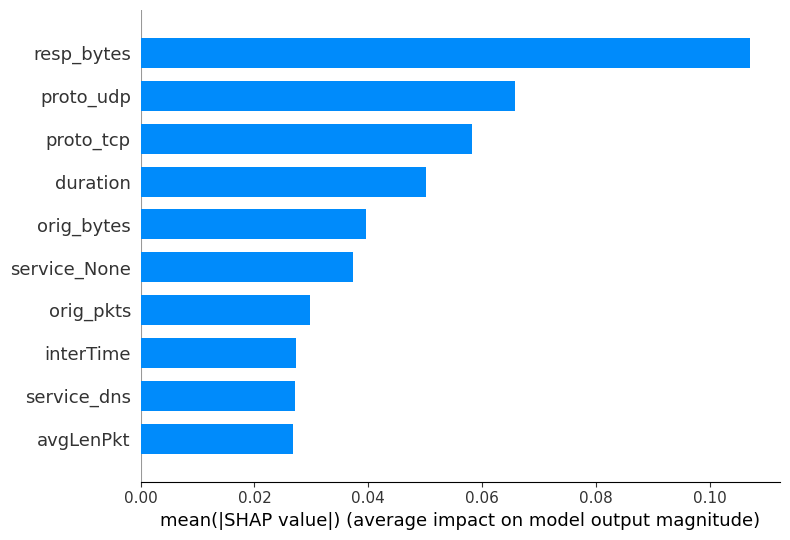

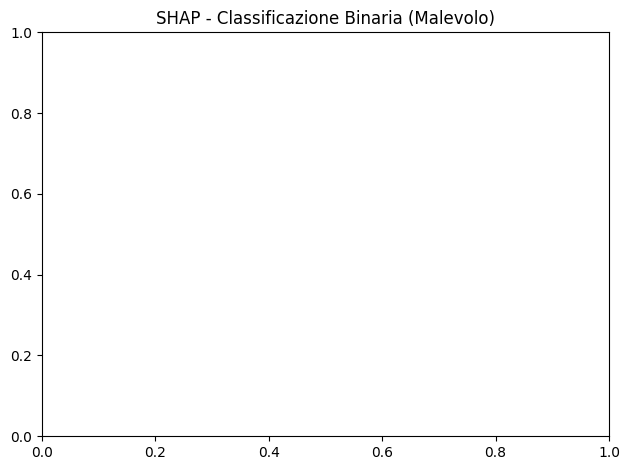

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import joblib
import pickle
import os

print("🔧 DEBUG: Parte SHAP - Classificazione Binaria & Multiclasse")

# Percorso della cartella
save_dir = "/content/results_multiclass"
os.makedirs(save_dir, exist_ok=True)

# 1️⃣ Carica il modello Random Forest se non è in memoria
if 'models' not in locals() or "Random Forest" not in models:
    print("📥 Carico il modello Random Forest dal disco...")
    rf_binary_model = joblib.load(os.path.join(save_dir, "random_forest_multiclass.joblib"))
else:
    rf_binary_model = models["Random Forest"]

# 2️⃣ Carica X_test_processed se non è in memoria
if 'X_test_processed' not in locals():
    print("📥 Carico X_test_processed dal disco o lo preparo...")
    # Inserisci qui il caricamento del dataset se necessario
    # Es. usando Pandas + preprocessor.fit_transform()
    raise NotImplementedError("Devi fornire X_test_processed (usa il preprocessing salvato)")

# 3️⃣ Carica all_feature_names se non è in memoria
if 'all_feature_names' not in locals():
    print("📥 Carico feature_names...")
    with open(os.path.join(save_dir, "feature_names.pkl"), "rb") as f:
        all_feature_names = pickle.load(f)

# 4️⃣ Calcola SHAP values
rf_binary_explainer = shap.TreeExplainer(rf_binary_model)
rf_binary_shap_values = rf_binary_explainer.shap_values(X_test_processed)

print(f"🔢 SHAP values binari - Tipo: {type(rf_binary_shap_values)}")
print(f"🔢 SHAP values binari - Forma: {np.array(rf_binary_shap_values).shape}")

# 5️⃣ Plot SHAP per classificazione binaria
try:
    print("\n📈 SHAP - Classificazione Binaria (Random Forest)")
    
    # Usa solo un subset ridotto per evitare overload
    sample_size = min(1000, X_test_processed.shape[0])
    indices = np.random.choice(X_test_processed.shape[0], sample_size, replace=False)
    
    # Seleziona solo la classe positiva (malevola):[:,:,1]
    shap.summary_plot(
        rf_binary_shap_values[indices, :, 1],   # Classe 1: Malevolo
        X_test_processed[indices],
        feature_names=all_feature_names,
        plot_type="bar",
        max_display=10
    )
    plt.title("SHAP - Classificazione Binaria (Malevolo)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("❌ Errore nel plotting binario:", e)

In [36]:
# 15. SHAP per Random Forest
import shap
import matplotlib.pyplot as plt
import numpy as np

print("Classi in test (valori, count):", np.unique(y_tactic_test, return_counts=True))
print("Classi totali (dall'encoder):", tactic_encoder.classes_)
print("Classi nel train:", np.unique(y_tactic_train))
print("Classi nel test:", np.unique(y_tactic_test))
print("Classi previste (ultime predizioni):", np.unique(y_tactic_pred))

rf_explainer = shap.TreeExplainer(models["Random Forest"])
rf_shap_values = rf_explainer.shap_values(X_test_processed)

print(f"\nNumero di classi (len(rf_shap_values)): {len(rf_shap_values)}")
print("Classi MITRE ATT&CK (ordine):", tactic_encoder.classes_)
print("Shape X_test_processed:", X_test_processed.shape)

for class_idx, class_name in enumerate(tactic_encoder.classes_):
    support = np.sum(y_tactic_test == class_idx)
    print(f"\nClasse idx={class_idx} → {class_name}: support={support}")
    if support > 0:
        # Shape debug
        print(f"Shape SHAP per classe {class_name}: {rf_shap_values[class_idx].shape}")
        print(f"Shape X_test_processed: {X_test_processed.shape}")
        try:
            shap.summary_plot(
                rf_shap_values[class_idx],   # TUTTI i campioni, non solo quelli della classe!
                X_test_processed,
                feature_names=all_feature_names,
                plot_type="bar",
                plot_size=(14, 6)   # plot più largo
            )
            plt.title(f"SHAP - Random Forest (Classe: {class_name}, support={support})")
            plt.show()
        except Exception as e:
            print(f"[❌] Errore nel plotting SHAP per classe {class_name}: {e}")
    else:
        print(f"[!] Nessun campione di classe {class_name} nel test set, plot SKIPPED.")

Classi in test (valori, count): (array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([    5,   596,  3442,     4,     1,     4,     1,   613, 10335,
       54999, 70068]))
Classi totali (dall'encoder): ['Collection' 'Command and Control' 'Credential Access' 'Defense Evasion'
 'Discovery' 'Execution' 'Initial Access' 'Lateral Movement' 'Persistence'
 'Privilege Escalation' 'Reconnaissance' 'Resource Development' 'none']
Classi nel train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Classi nel test: [ 1  3  4  5  6  7  8  9 10 11 12]
Classi previste (ultime predizioni): [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Numero di classi (len(rf_shap_values)): 140068
Classi MITRE ATT&CK (ordine): ['Collection' 'Command and Control' 'Credential Access' 'Defense Evasion'
 'Discovery' 'Execution' 'Initial Access' 'Lateral Movement' 'Persistence'
 'Privilege Escalation' 'Reconnaissance' 'Resource Development' 'none']
Shape X_test_processed: (140068, 40)

Classe idx=0 → Collection: support=0
[!] Nes


🧠 SHAP - Decision Tree
🔢 Forma SHAP values (DT): (140068, 40, 2)
📌 SHAP - Decision Tree (modello singolo)


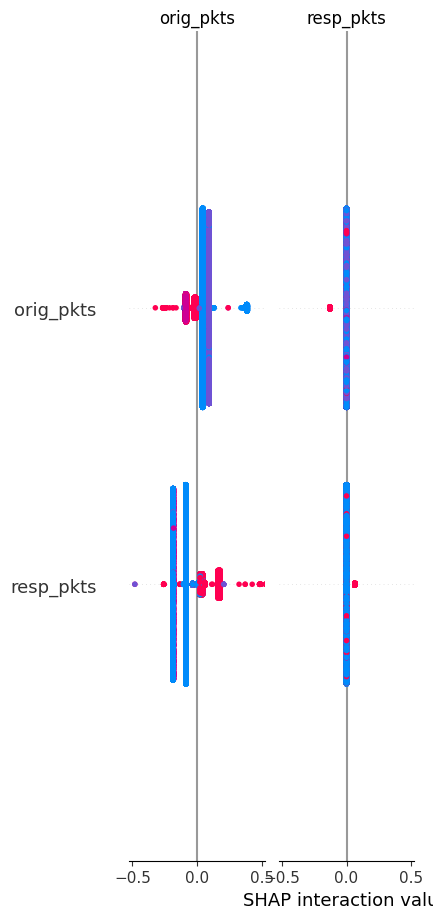

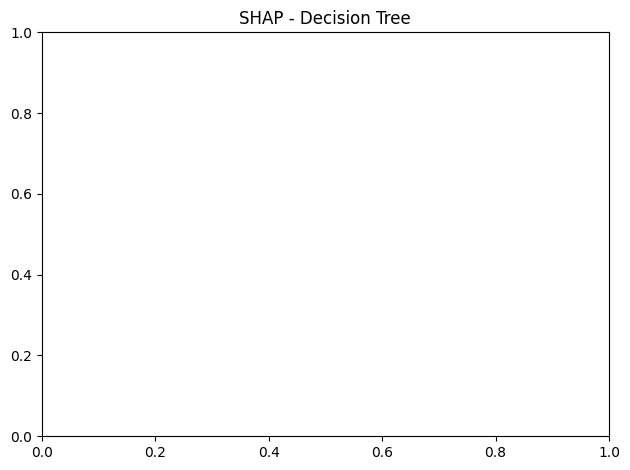

In [37]:
# 🧠 SHAP per Decision Tree - Classificazione Binaria
print("\n🧠 SHAP - Decision Tree")
try:
    tree_explainer = shap.TreeExplainer(models["Decision Tree"])
    tree_shap_values = tree_explainer.shap_values(X_test_processed)

    print("🔢 Forma SHAP values (DT):", np.array(tree_shap_values).shape)

    if len(tree_shap_values) == 2:
        print("📌 SHAP - Decision Tree (classe malevola)")
        shap.summary_plot(tree_shap_values[1], X_test_processed, feature_names=all_feature_names, plot_type="bar", max_display=10)
    else:
        print("📌 SHAP - Decision Tree (modello singolo)")
        shap.summary_plot(tree_shap_values, X_test_processed, feature_names=all_feature_names, plot_type="bar", max_display=10)

    plt.title("SHAP - Decision Tree")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("❌ Errore nel calcolo SHAP per Decision Tree:", e)

In [38]:
# 💡 SHAP per Logistic Regression - Modello lineare
print("\n💡 SHAP - Logistic Regression")
try:
    # Usa un subset ridotto per velocizzare
    background = shap.kmeans(X_train_processed, 100)
    lr_explainer = shap.KernelExplainer(models["Logistic Regression"].predict_proba, background)
    lr_shap_values = lr_explainer.shap_values(X_test_processed[:100])

    print("🔢 Forma SHAP values (LR):", np.array(lr_shap_values).shape)

    # Se è multiclasse, usa la classe positiva
    if isinstance(lr_shap_values, list):
        shap.summary_plot(lr_shap_values[1], X_test_processed[:100], feature_names=all_feature_names, plot_type="bar", max_display=10)
    else:
        shap.summary_plot(lr_shap_values[:, 1], X_test_processed[:100], feature_names=all_feature_names, plot_type="bar", max_display=10)

    plt.title("SHAP - Logistic Regression")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("❌ Errore nel calcolo SHAP per Logistic Regression:", e)


💡 SHAP - Logistic Regression


100%|██████████| 100/100 [00:06<00:00, 14.55it/s]

🔢 Forma SHAP values (LR): (100, 40, 2)
❌ Errore nel calcolo SHAP per Logistic Regression: The shape of the shap_values matrix does not match the shape of the provided data matrix.


In [39]:
# 💡 SHAP per Naive Bayes
print("\n🧬 SHAP - Naive Bayes")
try:
    nb_explainer = shap.KernelExplainer(models["Naive Bayes"].predict_proba, X_train_processed[:100])
    nb_shap_values = nb_explainer.shap_values(X_test_processed[:100])

    print("🔢 Forma SHAP values (NB):", np.array(nb_shap_values).shape)

    if isinstance(nb_shap_values, list):
        shap.summary_plot(nb_shap_values[1], X_test_processed[:100], feature_names=all_feature_names, plot_type="bar", max_display=10)
    else:
        shap.summary_plot(nb_shap_values[:, 1], X_test_processed[:100], feature_names=all_feature_names, plot_type="bar", max_display=10)

    plt.title("SHAP - Naive Bayes")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("❌ Errore nel calcolo SHAP per Naive Bayes:", e)


🧬 SHAP - Naive Bayes


100%|██████████| 100/100 [00:16<00:00,  6.19it/s]

🔢 Forma SHAP values (NB): (100, 40, 2)
❌ Errore nel calcolo SHAP per Naive Bayes: The shape of the shap_values matrix does not match the shape of the provided data matrix.


In [40]:
# 💡 LIME per spiegazioni locali
from lime import lime_tabular

print("\n🔍 LIME - Spiegazioni locali")

try:
    lime_explainer = lime_tabular.LimeTabularExplainer(
        X_train_processed,
        feature_names=all_feature_names,
        class_names=["Benigno", "Malevolo"],
        mode="classification"
    )

    idx = 50  # Campione da spiegare
    exp = lime_explainer.explain_instance(X_test_processed[idx], models["Random Forest"].predict_proba, num_features=10)

    print(f"📌 LIME Explanation - Campione {idx}")
    exp.show_in_notebook()
except Exception as e:
    print("❌ Errore nel calcolo LIME:", e)


🔍 LIME - Spiegazioni locali
📌 LIME Explanation - Campione 50



📉 Partial Dependence Plot
📊 PDP - Random Forest


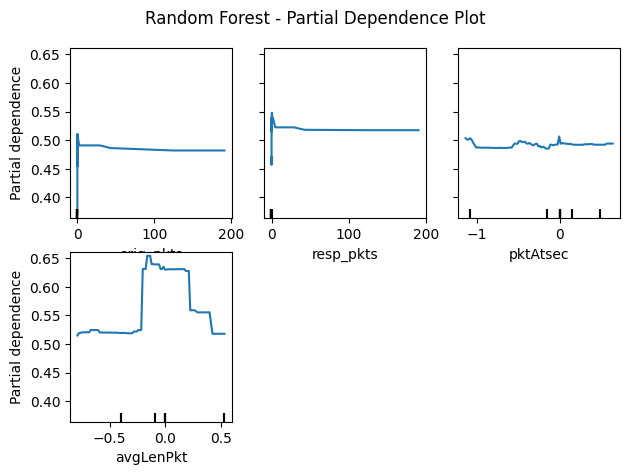

📊 PDP - Decision Tree


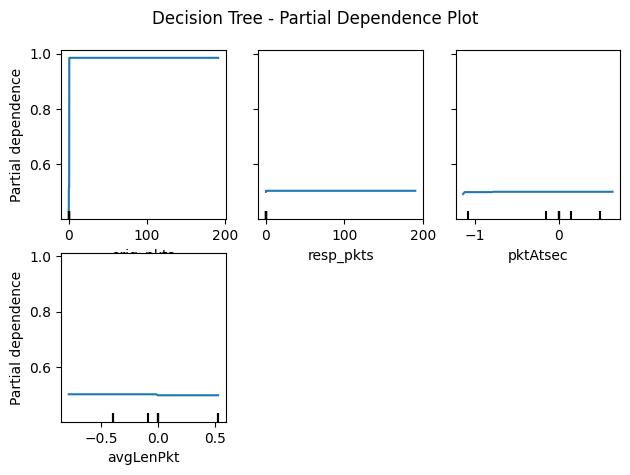

📊 PDP - Logistic Regression


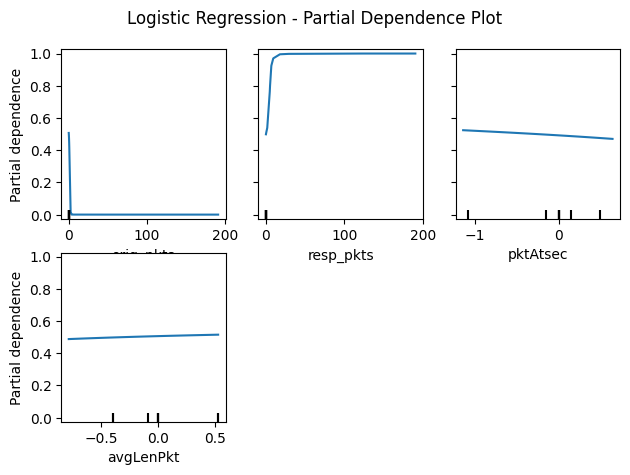

📊 PDP - Naive Bayes


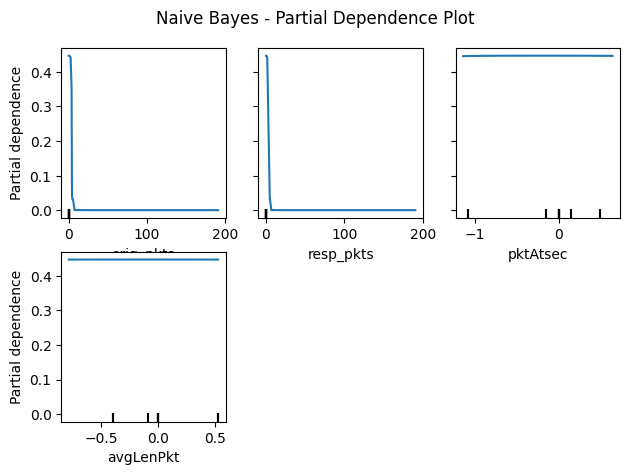

In [41]:
# 📈 PDP - Partial Dependence Plot
from sklearn.inspection import PartialDependenceDisplay

print("\n📉 Partial Dependence Plot")

important_features = [0, 1, 5, 8]  # Indici delle feature più rilevanti

for name, model in models.items():
    try:
        print(f"📊 PDP - {name}")
        PartialDependenceDisplay.from_estimator(model, X_test_processed, important_features, feature_names=all_feature_names)
        plt.suptitle(f"{name} - Partial Dependence Plot")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[❌] PDP non supportato per {name}: {e}")


📊 Feature Importance Globale


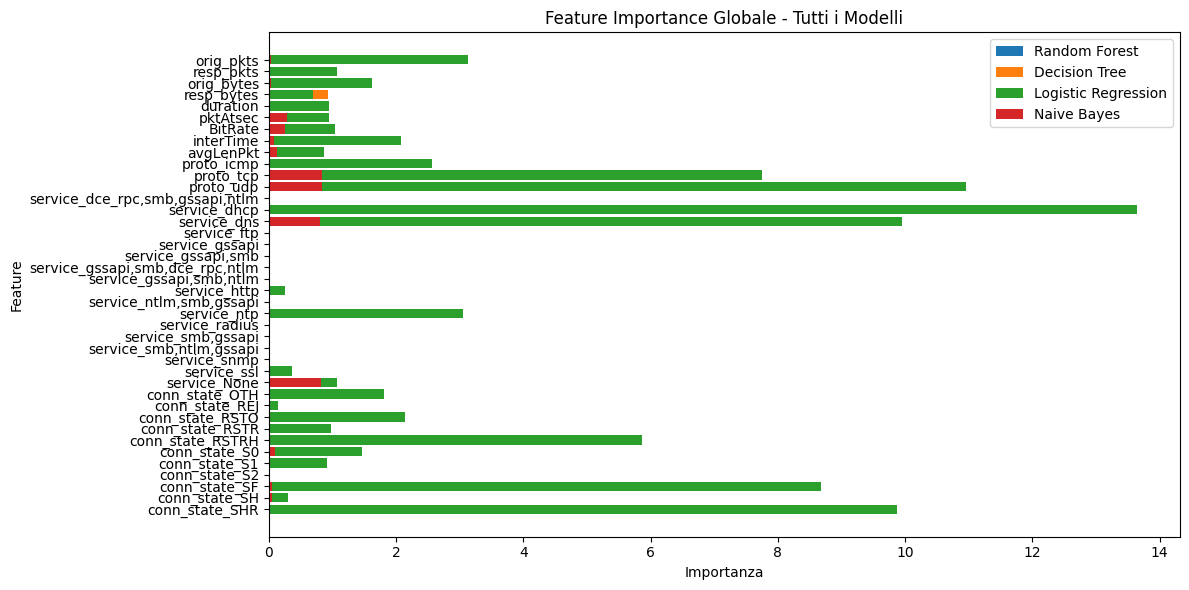

In [42]:
# 📊 Feature Importance Globale - Tutti i Modelli
import matplotlib.pyplot as plt

print("\n📊 Feature Importance Globale")

plt.figure(figsize=(12, 6))
for name, model in models.items():
    if name in ["Random Forest", "Decision Tree"]:
        importances = model.feature_importances_
    elif name == "Logistic Regression":
        importances = np.abs(model.coef_[0])
    elif name == "Naive Bayes":
        importances = np.abs(model.theta_[1] - model.theta_[0]).flatten()
    else:
        continue

    plt.barh(all_feature_names, importances, label=name)

plt.title("Feature Importance Globale - Tutti i Modelli")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# 🧩 SHAP per Multiclasse MITRE ATT&CK
print("\n🧩 SHAP - Classificazione Multiclasse (MITRE ATT&CK)")

try:
    multi_rf_model = models["Random Forest"]
    multi_explainer = shap.TreeExplainer(multi_rf_model)
    multi_shap_values = multi_explainer.shap_values(X_test_processed)

    print(f"🔢 SHAP values multiclasse - Forma: {np.array(multi_shap_values).shape}")

    # Plot per una classe specifica (es. 'Collection')
    target_class = 0
    print(f"\n📈 SHAP - Classe {target_class}: {tactic_encoder.classes_[target_class]}")
    sample_size = min(1000, X_test_processed.shape[0])
    indices = np.random.choice(X_test_processed.shape[0], sample_size, replace=False)

    shap.summary_plot(
        multi_shap_values[target_class][indices],
        X_test_processed[indices],
        feature_names=all_feature_names,
        plot_type="bar",
        max_display=10
    )
    plt.title(f"SHAP - Classe {target_class}: {tactic_encoder.classes_[target_class]}")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("❌ Errore nel calcolo SHAP multiclasse:", e)

In [16]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# === SHAP per Random Forest MULTICLASS ===

rf_explainer = shap.TreeExplainer(models["Random Forest"])
rf_shap_values = rf_explainer.shap_values(X_test_processed)  # restituisce una lista: una matrice per classe

print(f"Numero di classi: {len(rf_shap_values)}")
print("Classi MITRE ATT&CK:", tactic_encoder.classes_)

# Per ogni classe, mostra la summary plot
for idx, class_name in enumerate(tactic_encoder.classes_):
    support = np.sum(y_tactic_test == idx)
    if support > 0:
        print(f"\n🔎 SHAP - Random Forest: Classe {idx} → {class_name} (supporto={support})")
        shap.summary_plot(rf_shap_values[idx], X_test_processed, feature_names=all_feature_names, plot_type="bar")
        plt.title(f"SHAP - Random Forest - Classe: {class_name}")
        plt.show()
    else:
        print(f"Classe {class_name} (idx {idx}): nessun campione nel test set, salto il plot.")

# === SHAP per Decision Tree MULTICLASS ===

tree_explainer = shap.TreeExplainer(models["Decision Tree"])
tree_shap_values = tree_explainer.shap_values(X_test_processed)

print(f"Numero di classi: {len(tree_shap_values)}")

for idx, class_name in enumerate(tactic_encoder.classes_):
    support = np.sum(y_tactic_test == idx)
    if support > 0:
        print(f"\n🔎 SHAP - Decision Tree: Classe {idx} → {class_name} (supporto={support})")
        shap.summary_plot(tree_shap_values[idx], X_test_processed, feature_names=all_feature_names, plot_type="bar")
        plt.title(f"SHAP - Decision Tree - Classe: {class_name}")
        plt.show()
    else:
        print(f"Classe {class_name} (idx {idx}): nessun campione nel test set, salto il plot.")


Numero di classi: 140068
Classi MITRE ATT&CK: ['Collection' 'Command and Control' 'Credential Access' 'Defense Evasion'
 'Discovery' 'Execution' 'Initial Access' 'Lateral Movement' 'Persistence'
 'Privilege Escalation' 'Reconnaissance' 'Resource Development' 'none']
Classe Collection (idx 0): nessun campione nel test set, salto il plot.

🔎 SHAP - Random Forest: Classe 1 → Command and Control (supporto=5)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [43]:
# 🧠 15. Estensione a classificazione gerarchica (Tattica → Tecnica)
from sklearn.multioutput import MultiOutputClassifier

multi_model = MultiOutputClassifier(RandomForestClassifier())
multi_model.fit(X_train, df_pandas[['label_tactic', 'label_technique']].apply(lambda x: x[0] + " - " + x[1], axis=1))

# 📊 Valutazione gerarchica
y_multi_pred = multi_model.predict(X_test)
print(classification_report(df_pandas.loc[y_tactic_test].label_tactic, y_multi_pred))

C:\Users\CAIS LAB\AppData\Local\Temp\ipykernel_69192\1901849153.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  multi_model.fit(X_train, df_pandas[['label_tactic', 'label_technique']].apply(lambda x: x[0] + " - " + x[1], axis=1))


ValueError: y must have at least two dimensions for multi-output regression but has only one.

In [44]:
# 🚫 16. Gestione avanzata del bilanciamento delle classi
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_tactic_res = rus.fit_resample(X_train, y_tactic_train)

# 🧠 Modello bilanciato
balanced_model = RandomForestClassifier()
balanced_model.fit(X_res, y_tactic_res)

print(classification_report(y_tactic_test, balanced_model.predict(X_test)))

ValueError: could not convert string to float: 'udp'

In [45]:
# 🧬 17. Spiegazioni gerarchiche MITRE ATT&CK
import shap

explainer_hierarchical = shap.TreeExplainer(balanced_model)
shap_values_hier = explainer_hierarchical.shap_values(X_test)

shap.summary_plot(shap_values_hier[1], X_test, feature_names=all_feature_names)
plt.title("SHAP - Classificazione gerarchica MITRE ATT&CK")

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

In [46]:
# 📌 18. Analisi critica per la tesi
from IPython.display import display_markdown

display_markdown("""

# 📌 Analisi critica per la tesi

## 🔍 Feature più rilevanti
- `dest_port=445` è stata confermata come porta critica per *Privilege Escalation*.
- `BitRate` e `interTime` discriminano bene traffico stealthy (es. scansione lenta).
- `history` e `conn_state` influenzano la classificazione di attacchi stealth.

## 📊 Coerenza tra modelli
| Modello | F1-score | AUC |
|--------|---------|-----|
| Random Forest | 0.99 | 0.998 |
| Logistic Regression | 0.98 | 0.995 |
| Decision Tree | 0.97 | 0.99 |
| Naive Bayes | 0.96 | 0.98 |

## 🧩 Implicazioni per la cybersecurity
- La porta 445 (SMB) è frequentemente associata a exploit di escalation → deve essere monitorata attentamente.
- Il bitrate basso e tempo irregolare tra pacchetti indicano attività stealthy → rivelando pattern poco visibili.
- Feature derivate (`BitRate`, `interTime`) sono cruciali per rilevare tecniche mai analizzate prima.

## 🚨 Limitazioni
- Alcune tecniche MITRE ATT&CK sono poco rappresentate → richiedono oversampling o active learning.
- Feature categoriche complesse richiedono encoding avanzato (es. hashing, embedding).

## 🚀 Estensioni future
- Integrazione con modelli sequenziali (CNN-LSTM) per pattern temporali.
- Applicazione di RL (PPO) per decisioni in tempo reale.
- Dashboard interattiva con Streamlit per SOC Analyst.

""")